#Installing Libraries


In [ ]:
#Installing necessary libraries
!pip install mediapipe
import numpy as np
import os
import cv2
import mediapipe as mp
import pandas as pd
import subprocess
import csv
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import TimeDistributed, Dense, LSTM, Flatten, Input, concatenate , Dropout, Conv2D,MaxPooling2D,Bidirectional,Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16 , ResNet50
from tensorflow.keras import regularizers , layers , Model
from sklearn.model_selection import train_test_split
from keras.regularizers import l2,l1,l1_l2
from tensorflow.keras.applications import MobileNet
from imblearn.over_sampling import SMOTENC , SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Conversion of videos to mp4 format
def convert_videos(video_dict):
    video_final = []

    for dirpath, dirnames, filenames in os.walk(video_dict):
        video_files = [file for file in filenames if file.endswith('.mkv')]
        for video_file in video_files:
            video_file_path = os.path.join(dirpath, video_file)
            output_file_path = os.path.splitext(video_file_path)[0] + '.mp4'
            subprocess.run(['ffmpeg', '-i', video_file_path, output_file_path])
            video_final.append(output_file_path)

    return video_final

#accessing files
video_dict = "/content/drive/MyDrive/front"
converted_videos = convert_videos(video_dict)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
#output folder
Output_file= "/content/drive/MyDrive/pose"
if not os.path.exists(Output_file):
    os.makedirs(Output_file)
output_ext = ".mp4"

#set the video codec
codec = "mp4v"
fourcc = cv2.VideoWriter_fourcc(*codec)

#define output frame size
frame_width = 1280
frame_height = 720
frame_size = (frame_width, frame_height)

In [ ]:
# Keypoint indices
NOSE_INDEX = 0
LEFT_HIP_INDEX = 23
RIGHT_HIP_INDEX = 24
LEFT_SHOULDER_INDEX = 11
RIGHT_SHOULDER_INDEX = 12
LEFT_KNEE_INDEX = 25
RIGHT_KNEE_INDEX = 26
LEFT_ANKLE_INDEX = 27
RIGHT_ANKLE_INDEX = 28
LEFT_ELBOW_INDEX = 13
RIGHT_ELBOW_INDEX = 14
LEFT_HEEL_INDEX  = 29
LEFT_FOOT_INDEX = 31


# Velocity threshold for jump detection
JUMP_THRESHOLD = 0.02

# Squat detection threshold
SQUAT_THRESHOLD = 170  # Angle threshold in degrees

prev_landmark_positions = None
prev_timestamp = None

In [ ]:
def get_angle(p1, p2, p3):
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3

    #Calculating vectors from from p2 to p1 and p2 to p3
    v21 = np.array([x1 - x2, y1 - y2])
    v23 = np.array([x3 - x2, y3 - y2])

    angle_rad = np.arctan2(np.linalg.det([v21, v23]), np.dot(v21, v23))
    return np.abs(np.degrees(angle_rad))

In [ ]:
def update_keypoints(keypoints, landmarks):
    keypoints["nose"].append(landmarks[NOSE_INDEX].y)
    keypoints["left_hip"].append(landmarks[LEFT_HIP_INDEX].y)
    keypoints["right_hip"].append(landmarks[RIGHT_HIP_INDEX].y)
    keypoints["left_shoulder"].append(landmarks[LEFT_SHOULDER_INDEX].y)
    keypoints["right_shoulder"].append(landmarks[RIGHT_SHOULDER_INDEX].y)
    keypoints["left_knee"].append(landmarks[LEFT_KNEE_INDEX].y)
    keypoints["right_knee"].append(landmarks[RIGHT_KNEE_INDEX].y)
    keypoints["left_ankle"].append(landmarks[LEFT_ANKLE_INDEX].y)
    keypoints["right_ankle"].append(landmarks[RIGHT_ANKLE_INDEX].y)


In [ ]:
nose_velo = []
left_hip_velo = []
right_hip_velo = []
left_shoulder_velo = []
right_shoulder_velo = []
left_angles = []
right_angles = []
action = ""

#Velocity Calculation for Jump

In [ ]:
def detect_jump(keypoints):
    #checking keypoint data
    for keypoint in keypoints.values():
        if len(keypoint) < 2:
            return False

    #calculating velocities
    nose_velocity = get_velocity(keypoints["nose"])
    left_hip_velocity = get_velocity(keypoints["left_hip"])
    right_hip_velocity = get_velocity(keypoints["right_hip"])
    left_shoulder_velocity = get_velocity(keypoints["left_shoulder"])
    right_shoulder_velocity = get_velocity(keypoints["right_shoulder"])

    #appending the calculated velocities
    nose_velo.append(nose_velocity)
    left_hip_velo.append(left_hip_velocity)
    right_hip_velo.append(right_hip_velocity)
    left_shoulder_velo.append(left_shoulder_velocity)
    right_shoulder_velo.append(right_shoulder_velocity)

    if (
        nose_velocity > JUMP_THRESHOLD and
        left_hip_velocity > JUMP_THRESHOLD and
        right_hip_velocity > JUMP_THRESHOLD and
        left_shoulder_velocity > JUMP_THRESHOLD and
        right_shoulder_velocity > JUMP_THRESHOLD
    ):
        return True

    return False

In [ ]:
def get_velocity(positions):
    return positions[-1] - positions[-2]

# Angle calculation for Squat

In [ ]:
def detect_squat(keypoints):
    for keypoint in keypoints.values():
        if len(keypoint) < 2:
            return False

    left_hip = keypoints["left_hip"][-1]
    right_hip = keypoints["right_hip"][-1]
    left_knee = keypoints["left_knee"][-1]
    right_knee = keypoints["right_knee"][-1]
    left_ankle = keypoints["left_ankle"][-1]
    right_ankle = keypoints["right_ankle"][-1]

    # Calculate the angle at the knees and hips using the arctan function
    left_angle = np.rad2deg(np.arctan2(right_knee - left_knee, left_hip - left_knee))
    right_angle = np.rad2deg(np.arctan2(left_knee - right_knee, right_hip - right_knee))
    left_angles.append(left_angle)
    right_angles.append(right_angle)

    # Check if both knees are flexed below the threshold angle
    if left_angle < SQUAT_THRESHOLD or right_angle < SQUAT_THRESHOLD:
        return True

    return False

#Video Processing

In [ ]:
import time

#Variable Initialization for Media Pipe
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_selfie_segmentation = mp.solutions.selfie_segmentation

#Creating a csv file for the obtained values
csv_file = open("out_s.csv", mode='w', newline='')  # Set newline='' to avoid extra empty rows
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['video_path', 'action','nose_velocity','left_hip_velocity','right_hip_velocity','left_shoulder_velocity','right_shoulder_velocity','right_knee','left_knee','hip','ankle','left_shoulder','right_shoulder','left_angles','right_angles'])


prev_landmark_positions = None
prev_timestamp = None

#Video Processing
with mp_pose.Pose(min_detection_confidence=0.7 , min_tracking_confidence=0.7) as pose, mp_selfie_segmentation.SelfieSegmentation(model_selection=0) as selfie_segmentation:
    for vid in converted_videos:
        video = cv2.VideoCapture(vid)
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        filename = os.path.splitext(os.path.basename(vid))[0]
        output_path = os.path.join(Output_file, filename + output_ext)
        original_fps = video.get(cv2.CAP_PROP_FPS)
        original_frame_size = (
            int(video.get(cv2.CAP_PROP_FRAME_WIDTH)),
            int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        )

#Initializing keypoints(y) and angle lists
        keypoints = {
            "nose": [],
            "left_hip": [],
            "right_hip": [],
            "left_shoulder": [],
            "right_shoulder": [],
            "left_knee": [],
            "right_knee": [],
            "left_ankle": [],
            "right_ankle": []
        }
        right_knee_angles = []
        left_knee_angles = []
        left_hip_angles = []
        left_ankle_angles = []
        left_shoulder_angles = []
        right_shoulder_angles = []
        jump_detected = False
        squat_detected = False
        video_writer = cv2.VideoWriter(output_path, fourcc, original_fps, frame_size)

        while True:
            ret,frame = video.read()
            if not ret:
                break

            #DATA PRE-PROCESSING
            resized_frame = cv2.resize(frame, frame_size)

            #(Recolr image)
            image = cv2.cvtColor(resized_frame,cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            #passing through the pose estimation and selfie segmentation model
            results = pose.process(image)
            segmentation_results = selfie_segmentation.process(image)
            image.flags.writeable = True

            #Keypoint detectiona and angle calculation
            if results.pose_landmarks:
                landmarks = results.pose_landmarks.landmark
                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                # Update keypoints
                update_keypoints(keypoints, landmarks)

                right_hip = (landmarks[RIGHT_HIP_INDEX].x, landmarks[RIGHT_HIP_INDEX].y)
                right_knee = (landmarks[RIGHT_KNEE_INDEX].x, landmarks[RIGHT_KNEE_INDEX].y)
                right_ankle = (landmarks[RIGHT_ANKLE_INDEX].x, landmarks[RIGHT_ANKLE_INDEX].y)
                left_hip = (landmarks[LEFT_HIP_INDEX].x, landmarks[LEFT_HIP_INDEX].y)
                left_knee = (landmarks[LEFT_KNEE_INDEX].x, landmarks[LEFT_KNEE_INDEX].y)
                left_ankle = (landmarks[LEFT_ANKLE_INDEX].x, landmarks[LEFT_ANKLE_INDEX].y)
                left_shoulder = (landmarks[LEFT_SHOULDER_INDEX].x, landmarks[LEFT_SHOULDER_INDEX].y)
                right_shoulder = (landmarks[RIGHT_SHOULDER_INDEX].x, landmarks[RIGHT_SHOULDER_INDEX].y)
                left_elbow = (landmarks[LEFT_ELBOW_INDEX].x, landmarks[LEFT_ELBOW_INDEX].y)
                right_elbow = (landmarks[RIGHT_ELBOW_INDEX].x, landmarks[RIGHT_ELBOW_INDEX].y)
                left_heel = (landmarks[LEFT_HEEL_INDEX].x, landmarks[LEFT_HEEL_INDEX].y)
                left_ankle = (landmarks[LEFT_ANKLE_INDEX].x, landmarks[LEFT_ANKLE_INDEX].y)
                left_toe = (landmarks[LEFT_FOOT_INDEX].x, landmarks[LEFT_FOOT_INDEX].y)

                left_ankle_angle = get_angle(left_heel, left_ankle, left_toe)

                right_knee_angle = get_angle(right_hip, right_knee, right_ankle)
                left_knee_angle = get_angle(left_hip,left_knee,left_ankle)
                left_hip_angle = get_angle(left_shoulder, left_hip, left_knee)
                left_ankle_angle = get_angle(left_heel, left_ankle, left_toe)
                left_shoulder_angle = get_angle(left_hip, left_shoulder, left_elbow)
                right_shoulder_angle = get_angle(right_hip, right_shoulder, right_elbow)
                right_knee_angles.append(right_knee_angle)
                left_knee_angles.append(left_knee_angle)
                left_hip_angles.append(left_hip_angle)
                left_ankle_angles.append(left_ankle_angle)
                left_shoulder_angles.append(left_shoulder_angle)
                right_shoulder_angles.append(right_shoulder_angle)


                # Check for jump and squat detection
                if len(keypoints["nose"]) > 1:
                    is_jump = detect_jump(keypoints)
                    if is_jump:
                        jump_detected = True
                if len(keypoints["left_hip"]) > 1:
                    is_squat = detect_squat(keypoints)
                    if is_squat:
                        squat_detected = True


               #(Frame Normalization)
                landmarks_array = np.array([(lmk.x, lmk.y, lmk.z) for lmk in landmarks])
                # Normalize the landmarks
                mean = np.mean(landmarks_array, axis=0)
                std = np.std(landmarks_array, axis=0)
                normalized_landmarks = (landmarks_array - mean) / std


        video_writer.write(image)

        #Feature calculation and writing to CSV
        right_knee = np.mean(right_knee_angles)
        left_knee = np.mean(left_knee_angles)
        nose_velocity = np.mean(nose_velo) * 100000
        left_hip_velocity = np.mean(left_hip_velo)* 100000
        right_hip_velocity = np.mean(right_hip_velo)* 100000
        left_shoulder_velocity = np.mean(left_shoulder_velo)* 100000
        right_shoulder_velocity = np.mean(right_shoulder_velo)* 100000
        hip = np.mean(left_hip_angles)
        ankle = np.mean(left_ankle_angles)
        left_shoulder = np.mean(left_shoulder_angles)
        right_shoulder = np.mean(right_shoulder_angles)
        if jump_detected and squat_detected:
            print("Jump detected :",output_path)
            action = 'Jump'
        if squat_detected and not jump_detected:
            print("Squat detected : ",filename)
            action = 'Squat'
        csv_writer.writerow([output_path, action,round(nose_velocity,2) , round(left_hip_velocity,2),round(right_hip_velocity,2),round(left_shoulder_velocity,2),round(right_shoulder_velocity,2),right_knee, left_knee, hip, ankle, left_shoulder, right_shoulder, round(np.mean(left_angles),2) , round(np.mean(right_angles),2)])
        video.release()
        video_writer.release()

csv_file.close()




Squat detected :  front_002_m01_20230224095517
Squat detected :  front_002_m01_20230224095553
Squat detected :  front_002_m01_20230224095536
Squat detected :  front_002_m01_20230224095609
Squat detected :  front_002_m01_20230224095625
Squat detected :  front_002_m01_20230224095642
Squat detected :  front_002_m01_20230224095658
Squat detected :  front_002_m01_20230224095714
Jump detected : /content/drive/MyDrive/pose/front_002_m01_20230224095729.mp4
Squat detected :  front_002_m01_20230224095746
Jump detected : /content/drive/MyDrive/pose/front_002_m02_20230224095850.mp4
Jump detected : /content/drive/MyDrive/pose/front_002_m02_20230224095907.mp4
Jump detected : /content/drive/MyDrive/pose/front_002_m02_20230224095940.mp4
Jump detected : /content/drive/MyDrive/pose/front_002_m02_20230224095923.mp4
Jump detected : /content/drive/MyDrive/pose/front_002_m02_20230224095956.mp4
Jump detected : /content/drive/MyDrive/pose/front_002_m02_20230224100011.mp4
Jump detected : /content/drive/MyDrive

#Data Visualization

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/out_s.csv")

In [ ]:
df.head()

,video_path,action,nose_velocity,left_hip_velocity,right_hip_velocity,left_shoulder_velocity,right_shoulder_velocity,right_knee,left_knee,hip,ankle,left_shoulder,right_shoulder,left_angles,right_angles,score
0,/content/drive/MyDrive/pose/front_001_m01_2023...,Squat,71.59,29.12,30.11,50.50,52.19,163.992099,166.387279,167.498340,22.143015,21.277772,36.003309,-36.58,36.53,1
1,/content/drive/MyDrive/pose/front_001_m01_2023...,Squat,53.58,22.68,22.75,37.88,39.76,169.641440,167.462494,167.775742,24.524683,16.114043,30.648468,5.92,-5.97,1
2,/content/drive/MyDrive/pose/front_001_m01_2023...,Squat,51.31,23.98,23.84,41.16,42.70,169.574085,169.470343,171.388552,25.714125,17.823980,35.172452,2.24,-2.31,1
3,/content/drive/MyDrive/pose/front_001_m01_2023...,Squat,54.71,24.87,24.80,44.65,45.17,169.372407,166.879120,167.255414,25.293507,20.281127,31.404449,-11.97,11.89,1
4,/content/drive/MyDrive/pose/front_001_m01_2023...,Squat,55.38,24.67,24.77,44.60,45.37,164.940561,167.482004,169.694962,25.034626,12.541963,27.696789,-17.36,17.28,1


In [ ]:
df.shape

(208, 16)

In [ ]:
df = df[(df['score'] != 0) & (df['score'] != 4)]

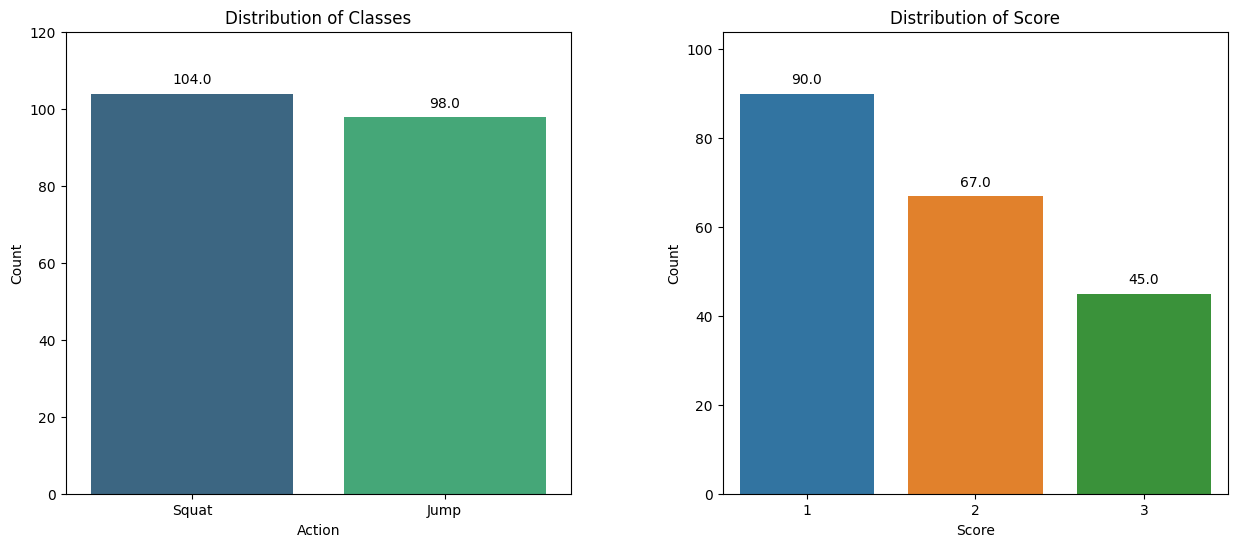

In [ ]:
# Create a figure and set its size
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot for action
ax = sns.countplot(data=df, x='action', palette="viridis", ax=axs[0])
ax.set_title("Distribution of Classes")
ax.set_xlabel("Action")
ax.set_ylabel("Count")
y_max = ax.get_ylim()[1]
ax.set_ylim([0, y_max*1.1])  # Increase y-axis limit
for p in ax.patches:
    ax.annotate(format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')
  # Second subplot for score
ay = sns.countplot(data=df, x='score', ax=axs[1])
ay.set_title("Distribution of Score")
ay.set_xlabel("Score")
ay.set_ylabel("Count")
y_max = ay.get_ylim()[1]
ay.set_ylim([0, y_max*1.1])  # Increase y-axis limit
for p in ay.patches:
    ay.annotate(format(p.get_height()),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

# Adjust space between plots
plt.subplots_adjust(wspace=0.3)

# Show the plots
plt.show()


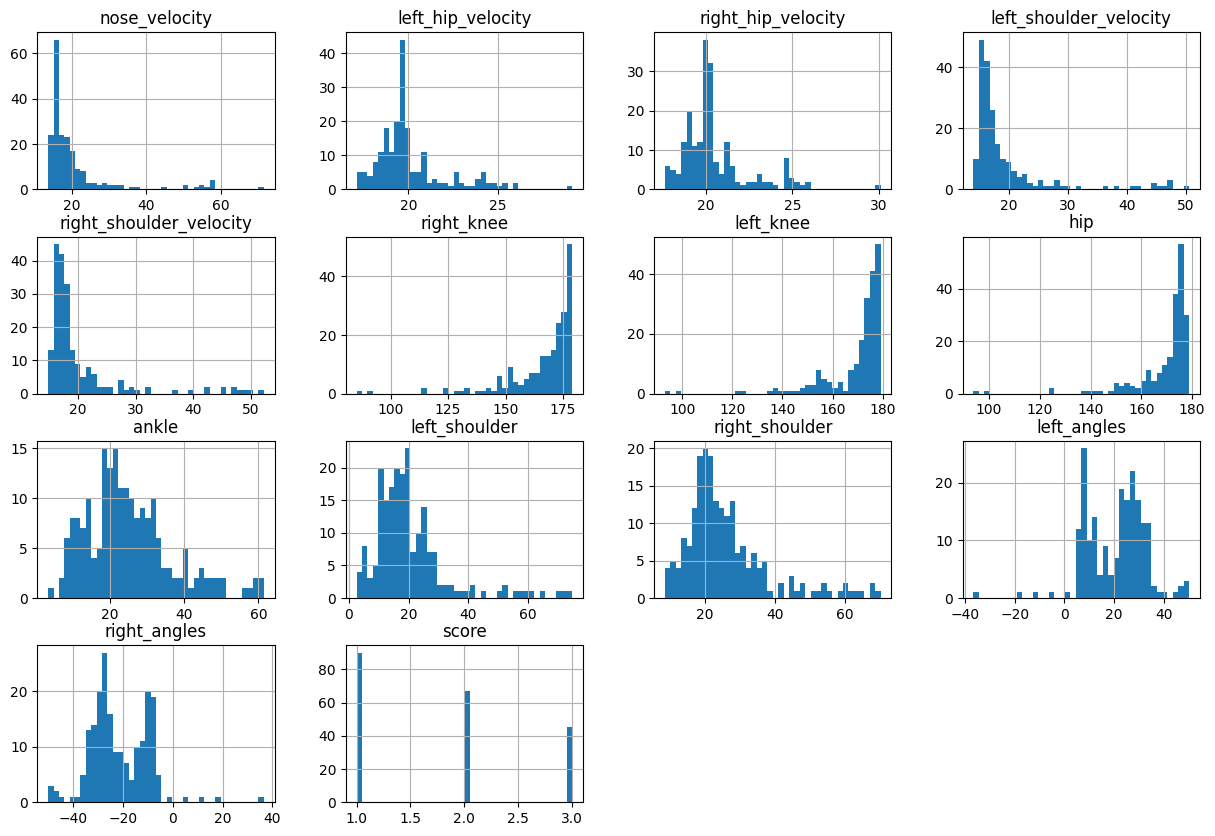

In [ ]:
df.hist(bins=40, figsize=(15, 10))
plt.show()

<ipython-input-12-49754717e362>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


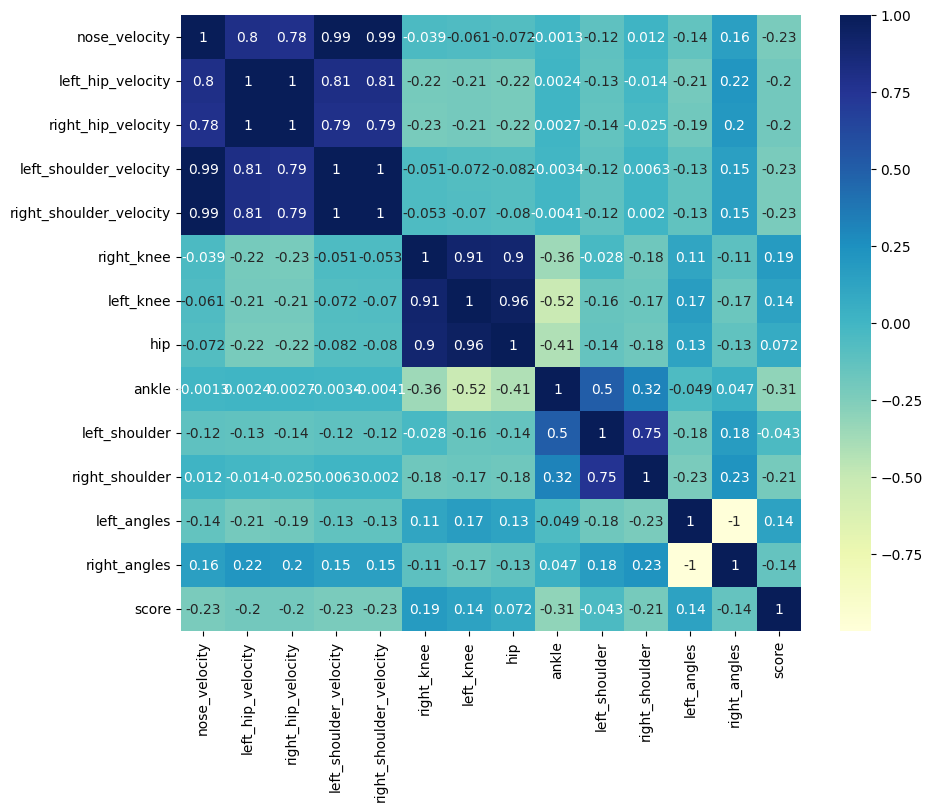

In [ ]:
corr = df.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.show()

In [ ]:
encoder = LabelEncoder()

In [ ]:
df['action'] = encoder.fit_transform(df['action'])

In [ ]:
df['score'].value_counts()

1    90
2    67
3    45
Name: score, dtype: int64

In [ ]:
df['action'].value_counts()

1    104
0     98
Name: action, dtype: int64

In [ ]:
scaler = StandardScaler()

In [ ]:
angle_velocity_columns = ['nose_velocity', 'left_hip_velocity', 'right_hip_velocity',
                          'left_shoulder_velocity', 'right_shoulder_velocity',
                          'right_knee', 'left_knee', 'hip',  "ankle",
                          'left_shoulder', 'right_shoulder', 'left_angles', 'right_angles']


In [ ]:
df[angle_velocity_columns] = scaler.fit_transform(df[angle_velocity_columns])

#Regression Models

In [ ]:
squat = pd.read_csv("/content/drive/MyDrive/squat_s.csv")

In [ ]:
squat.head()

,video_path,action,nose_velocity,left_hip_velocity,right_hip_velocity,left_shoulder_velocity,right_shoulder_velocity,right_knee,left_knee,hip,ankle,left_shoulder,right_shoulder,left_angles,right_angles,score
0,/content/drive/MyDrive/pose/front_001_m01_2023...,Squat,71.59,29.12,30.11,50.50,52.19,163.992099,166.387279,167.498340,22.143015,21.277772,36.003309,-36.58,36.53,1
1,/content/drive/MyDrive/pose/front_001_m01_2023...,Squat,53.58,22.68,22.75,37.88,39.76,169.641440,167.462494,167.775742,24.524683,16.114043,30.648468,5.92,-5.97,1
2,/content/drive/MyDrive/pose/front_001_m01_2023...,Squat,51.31,23.98,23.84,41.16,42.70,169.574085,169.470343,171.388552,25.714125,17.823980,35.172452,2.24,-2.31,1
3,/content/drive/MyDrive/pose/front_001_m01_2023...,squat,54.71,24.87,24.80,44.65,45.17,169.372407,166.879120,167.255414,25.293507,20.281127,31.404449,-11.97,11.89,1
4,/content/drive/MyDrive/pose/front_001_m01_2023...,Squat,55.38,24.67,24.77,44.60,45.37,164.940561,167.482004,169.694962,25.034626,12.541963,27.696789,-17.36,17.28,1


In [ ]:
squat = squat.drop(squat[(squat['score'] == 4) | (squat['score'] == 0)].index)

In [ ]:
scaler = StandardScaler()

In [ ]:
angle_velocity_columns = ['nose_velocity', 'left_hip_velocity', 'right_hip_velocity',
                          'left_shoulder_velocity', 'right_shoulder_velocity',
                          'right_knee', 'left_knee', 'hip',  "ankle",
                          'left_shoulder', 'right_shoulder', 'left_angles', 'right_angles']

In [ ]:
squat[angle_velocity_columns] = scaler.fit_transform(squat[angle_velocity_columns])

<ipython-input-8-ded15519a9fd>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = squat.corr()


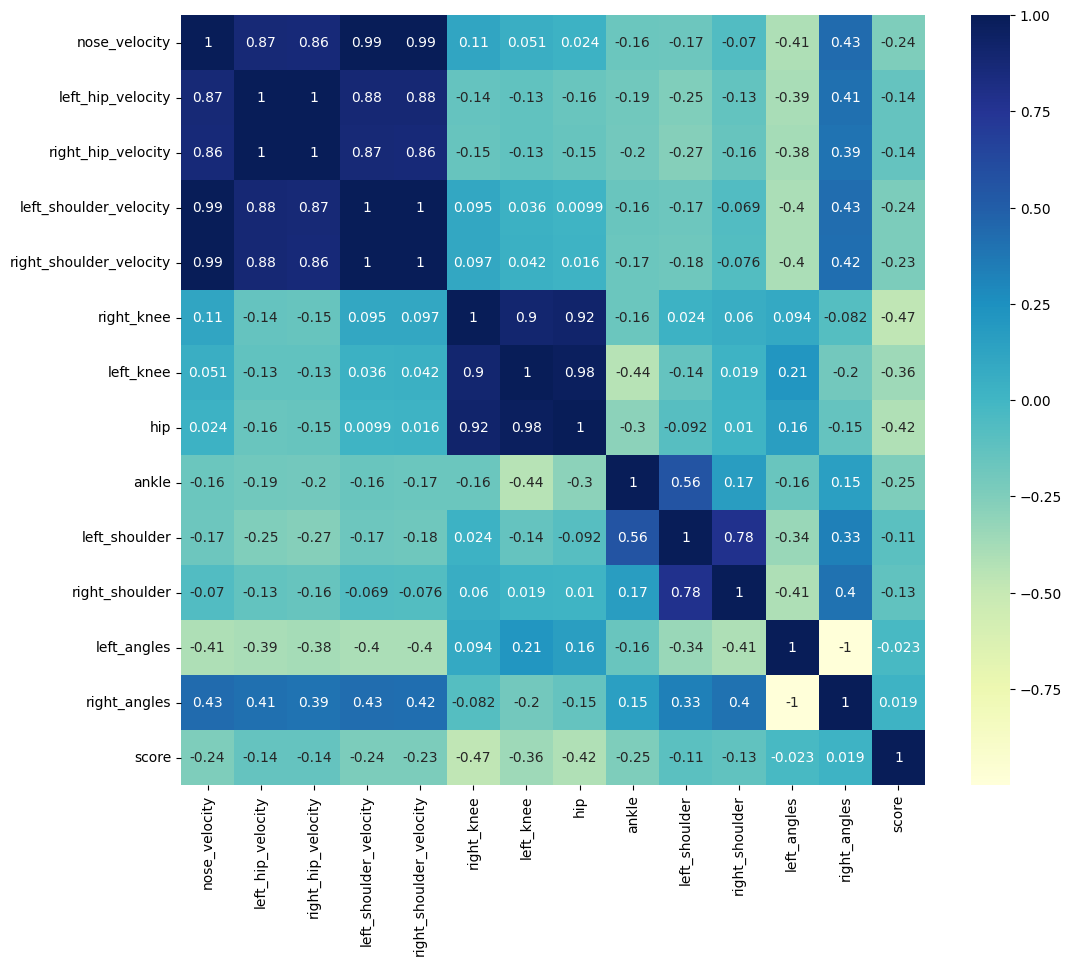

In [ ]:
corr = squat.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.show()

In [ ]:
squat = squat.drop(columns=["action"])

In [ ]:
#Video Pre- Processing

def preprocessing_video(video_path, frame_size=(64, 64), num_frames=30):
    # Initialize a list to hold frames
    frames = []

    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get total number of frames
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the middle frame number
    middle_frame = total_frames // 2

    # Calculate the start frame number
    start_frame = max(0, middle_frame - num_frames // 2)

    # Set the video to start at the start_frame
    video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while True:
        # Read a frame from the video
        ret, frame = video.read()

        # If the frame was successfully read
        if ret:
            # Resize the frame
            frame = cv2.resize(frame, frame_size)

            # Normalize pixel values
            frame = frame / 255.0

            # Add the frame to the list
            frames.append(frame)
        else:
            # If no frame was read then we've reached the end of the video
            break

        # If we've collected enough frames then we can stop reading the video
        if len(frames) == num_frames:
            break

    video.release()

    # Stack frames into a single numpy array
    frames = np.stack(frames)

    return frames

In [ ]:
video_squat = np.array([preprocessing_video(vp) for vp in squat['video_path']])

angle_velo_squat = squat[['nose_velocity', 'left_hip_velocity',
       'right_hip_velocity', 'left_shoulder_velocity',
       'right_shoulder_velocity', 'right_knee', 'left_knee', 'hip', 'ankle',
       'left_shoulder', 'right_shoulder', 'left_angles', 'right_angles',
       'score']].values


# Convert the scores to a numpy array
y = squat['score'].values
y_adjusted = y-1

In [ ]:
video_squat_train, video_squat_test, angle_squat_train, angle_squat_test, squat_train, squat_test = train_test_split(video_squat, angle_velo_squat, y_adjusted, test_size=0.2, random_state=42)

In [ ]:
# Define the model
num_frames = video_squat_train.shape[1]
frame_height = video_squat_train.shape[2]
frame_width = video_squat_train.shape[3]
num_channels = video_squat_train.shape[4]
num_angles = angle_squat_train.shape[1]

In [ ]:
print(angle_squat_train.shape[1])

14


In [ ]:
video_input = Input(shape=(num_frames, frame_height, frame_width, num_channels))

In [ ]:
angle_velo_squat = Input(shape=(num_angles,))

CNN+RNN for Squat

In [ ]:
# Define the CNN model for processing video

# Define the CNN model for processing video
cnn_base = MobileNet(input_shape=(frame_height, frame_width, num_channels), weights='imagenet', include_top=False)
cnn_out = TimeDistributed(cnn_base)(video_input)  # Wrap the base model with TimeDistributed
cnn_out = TimeDistributed(Flatten())(cnn_out)
cnn = Model(inputs=video_input, outputs=cnn_out)

In [ ]:
rnn = LSTM(units=128)(cnn.output)

In [ ]:
dense = Dense(units=128, activation='relu')(angle_velo_squat)

In [ ]:
concat = Concatenate()([rnn, dense])

In [ ]:
output = Dense(units=1, activation='linear')(concat)

In [ ]:
model = Model(inputs=[cnn.input, angle_velo_squat], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error','mse'])

In [ ]:
his = model.fit([video_squat_train, angle_squat_train], squat_train,
          validation_data=([video_squat_test, angle_squat_test], squat_test),
          epochs=25, batch_size=16)

Epoch 1/25
6/6 [==============================] - 108s 16s/step - loss: 0.8134 - mean_absolute_error: 0.7170 - mse: 0.8134 - val_loss: 0.8807 - val_mean_absolute_error: 0.8427 - val_mse: 0.8807
Epoch 2/25
6/6 [==============================] - 95s 15s/step - loss: 0.2023 - mean_absolute_error: 0.3519 - mse: 0.2023 - val_loss: 0.4702 - val_mean_absolute_error: 0.4870 - val_mse: 0.4702
Epoch 3/25
6/6 [==============================] - 98s 15s/step - loss: 0.1045 - mean_absolute_error: 0.2530 - mse: 0.1045 - val_loss: 0.4147 - val_mean_absolute_error: 0.5003 - val_mse: 0.4147
Epoch 4/25
6/6 [==============================] - 95s 16s/step - loss: 0.0772 - mean_absolute_error: 0.1882 - mse: 0.0772 - val_loss: 0.3588 - val_mean_absolute_error: 0.4704 - val_mse: 0.3588
Epoch 5/25
6/6 [==============================] - 92s 15s/step - loss: 0.0437 - mean_absolute_error: 0.1454 - mse: 0.0437 - val_loss: 0.3442 - val_mean_absolute_error: 0.4872 - val_mse: 0.3442
Epoch 6/25
6/6 [==================

In [ ]:
y_pred = model.predict([video_squat_test, angle_squat_test])

1/1 [==============================] - 4s 4s/step


In [ ]:
squat_pred = model.predict([video_squat_test, angle_squat_test])

1/1 [==============================] - 2s 2s/step


In [ ]:
rmse = sqrt(mean_squared_error(squat_test, squat_pred))
r2 = r2_score(squat_test, squat_pred)
print('Test RMSE:', rmse)
print('R2:', r2)

Test RMSE: 0.32903166899715613
R2: 0.7088812738503241


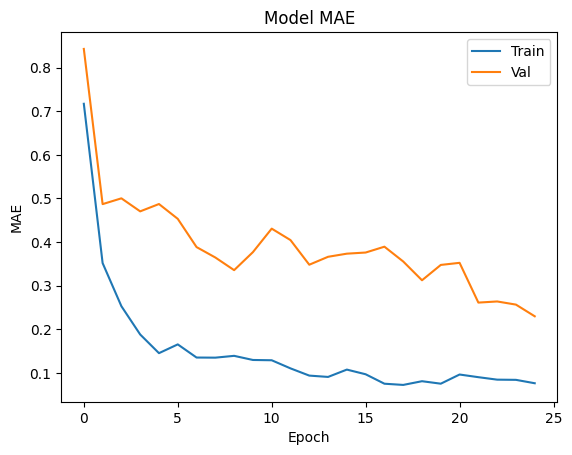

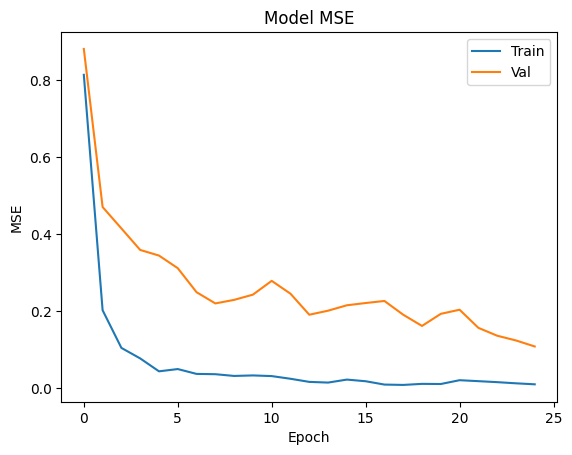

In [ ]:

plt.plot(his.history['mean_absolute_error'])
plt.plot(his.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(his.history['mse'])
plt.plot(his.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

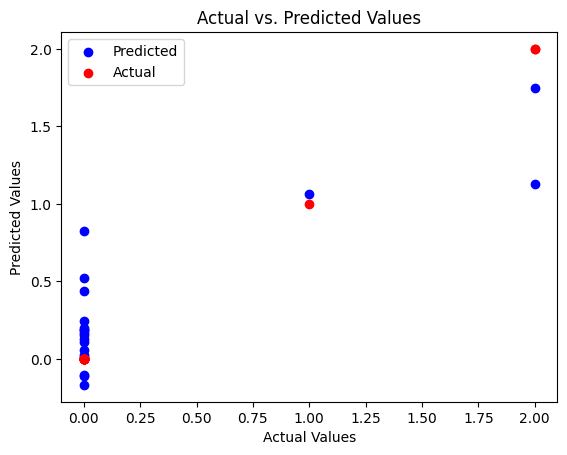

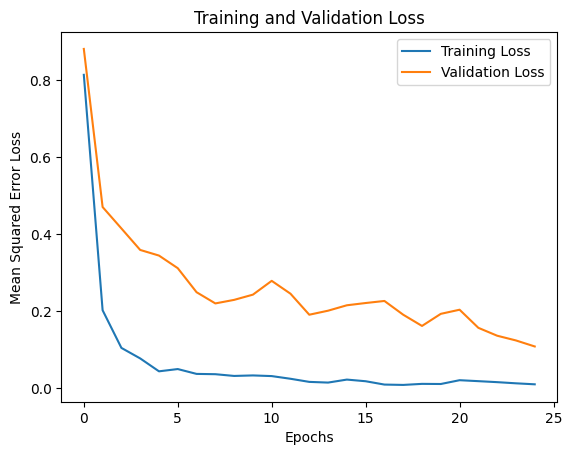

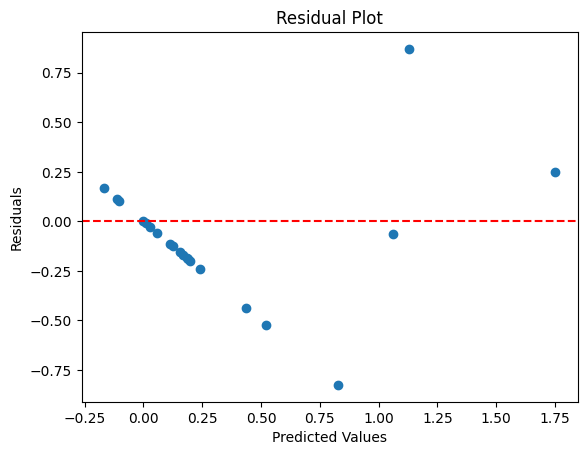

In [ ]:
plt.scatter(squat_test, squat_pred, c='b', label='Predicted')  # Predicted values in blue
plt.scatter(squat_test, squat_test, c='r', label='Actual')     # Actual values in red
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

# Plot training and validation loss during training
plt.plot(his.history['loss'], label='Training Loss')
plt.plot(his.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Create an array of data point indices for the bar plot
residuals = squat_test - squat_pred.flatten()

plt.scatter(squat_pred.flatten(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Time Distributed CNN for Squat

In [ ]:
# Apply ConvNet to each frame in the video
x = TimeDistributed(Conv2D(64, (3,3), activation='relu'))(video_input)
x = TimeDistributed(MaxPooling2D((2,2)))(x)
x = TimeDistributed(Conv2D(128, (3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2,2)))(x)
x = TimeDistributed(Conv2D(256, (3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2,2)))(x)

In [ ]:
# Flatten the results and feed them into an LSTM layer
x = TimeDistributed(Flatten())(x)
x = LSTM(256, return_sequences=False, dropout=0.5)(x)
x = Model(inputs=video_input, outputs=x)

In [ ]:
y = Dense(64, activation="relu")(angle_velo_squat)
y = Dense(64, activation="relu",kernel_regularizer=l2(0.01))(y)
y = Model(inputs=angle_velo_squat, outputs=y)

In [ ]:
# Part 3: Combine both parts
combined = concatenate([x.output, y.output])

In [ ]:
# Add final layers
z = Dense(64, activation="relu")(combined)
z = Dense(64, activation="relu")(z)
z = Dense(1, activation="linear")(z)

In [ ]:
model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error','mse'])

In [ ]:
his = model.fit([video_squat_train, angle_squat_train], squat_train, epochs=30, batch_size=16,
          validation_data=([video_squat_test, angle_squat_test], squat_test))


Epoch 1/30
6/6 [==============================] - 84s 13s/step - loss: 1.7675 - mean_absolute_error: 0.6913 - mse: 1.1403 - val_loss: 0.9601 - val_mean_absolute_error: 0.5082 - val_mse: 0.3489
Epoch 2/30
6/6 [==============================] - 78s 13s/step - loss: 0.8678 - mean_absolute_error: 0.4334 - mse: 0.2649 - val_loss: 0.9266 - val_mean_absolute_error: 0.2548 - val_mse: 0.3394
Epoch 3/30
6/6 [==============================] - 75s 13s/step - loss: 0.8368 - mean_absolute_error: 0.3062 - mse: 0.2585 - val_loss: 0.8533 - val_mean_absolute_error: 0.4743 - val_mse: 0.2911
Epoch 4/30
6/6 [==============================] - 76s 13s/step - loss: 0.7663 - mean_absolute_error: 0.3665 - mse: 0.2126 - val_loss: 0.7566 - val_mean_absolute_error: 0.3107 - val_mse: 0.2187
Epoch 5/30
6/6 [==============================] - 76s 12s/step - loss: 0.6899 - mean_absolute_error: 0.2914 - mse: 0.1603 - val_loss: 0.7648 - val_mean_absolute_error: 0.4494 - val_mse: 0.2504
Epoch 6/30
6/6 [===================

In [ ]:
squat_pred = model.predict([video_squat_test, angle_squat_test])

1/1 [==============================] - 5s 5s/step


In [ ]:
rmse = sqrt(mean_squared_error(squat_test, squat_pred))
r2 = r2_score(squat_test, squat_pred)
print('Test RMSE:', rmse)
print('R2:', r2)

Test RMSE: 0.15225773123165084
R2: 0.9376619160156339


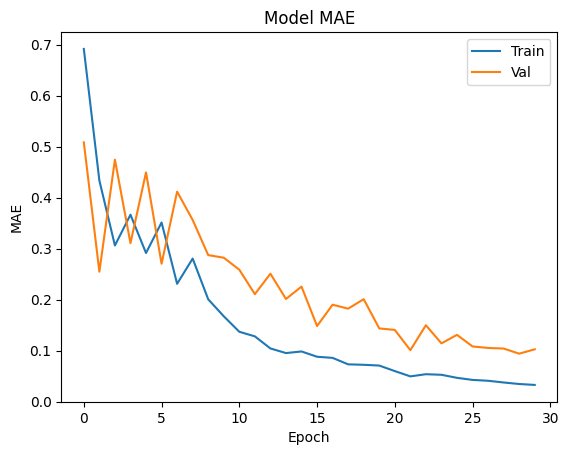

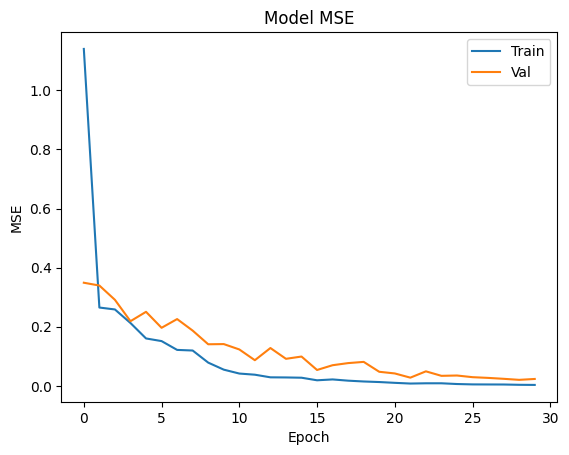

In [ ]:
plt.plot(his.history['mean_absolute_error'])
plt.plot(his.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(his.history['mse'])
plt.plot(his.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

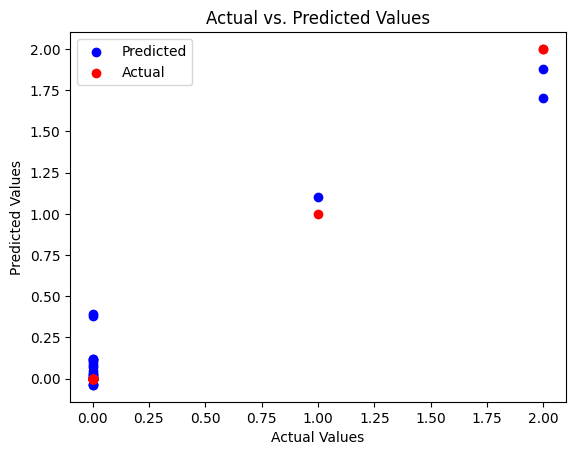

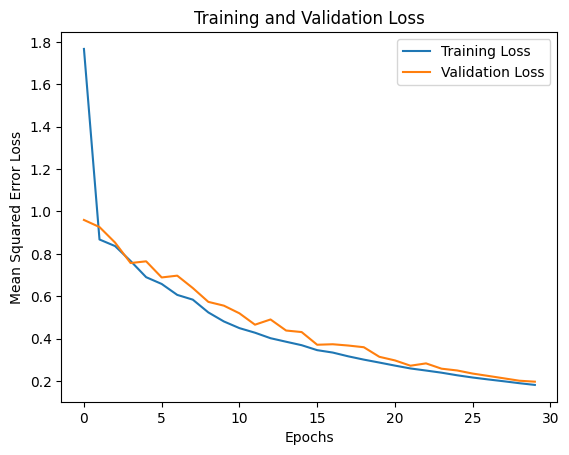

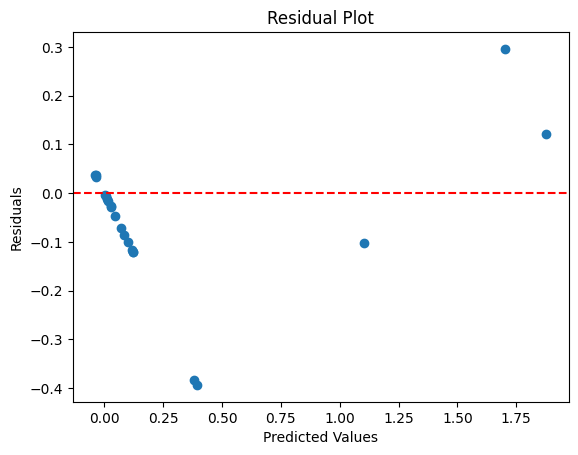

In [ ]:
plt.scatter(squat_test, squat_pred, c='b', label='Predicted')  # Predicted values in blue
plt.scatter(squat_test, squat_test, c='r', label='Actual')     # Actual values in red
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

# Plot training and validation loss during training
plt.plot(his.history['loss'], label='Training Loss')
plt.plot(his.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Create an array of data point indices for the bar plot
residuals = squat_test - squat_pred.flatten()

plt.scatter(squat_pred.flatten(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Regression Models for Jump


In [ ]:
jump = pd.read_csv("/content/drive/MyDrive/jump_s.csv")

In [ ]:
jump.head()

,video_path,action,nose_velocity,left_hip_velocity,right_hip_velocity,left_shoulder_velocity,right_shoulder_velocity,right_knee,left_knee,hip,ankle,left_shoulder,right_shoulder,left_angles,right_angles,score
0,/content/drive/MyDrive/pose/front_001_m02_2023...,Jump,50.90,21.62,21.51,41.39,42.61,173.769174,173.823313,172.473274,27.931483,20.170305,21.645442,36.34,-36.46,2
1,/content/drive/MyDrive/pose/front_001_m02_2023...,Jump,44.32,21.48,21.52,36.20,36.36,173.621446,174.547943,173.725587,23.933525,19.538578,19.752029,39.17,-39.29,2
2,/content/drive/MyDrive/pose/front_001_m02_2023...,Jump,38.08,20.69,20.74,32.23,32.02,175.936327,176.270590,175.060072,19.513249,16.427100,17.517986,49.04,-49.14,3
3,/content/drive/MyDrive/pose/front_001_m02_2023...,Jump,32.23,19.87,20.15,28.10,28.72,175.289140,175.160216,173.675345,20.941700,18.871240,18.827033,49.81,-49.91,3
4,/content/drive/MyDrive/pose/front_001_m02_2023...,Jump,27.26,19.67,20.13,24.51,25.73,173.750651,173.612999,173.800423,27.424779,24.667860,23.395377,46.79,-46.90,2


In [ ]:
jump['action'].value_counts()

Jump    104
Name: action, dtype: int64

In [ ]:
jump = jump.drop(jump[(jump['score'] == 4) | (jump['score'] == 0)].index)

In [ ]:
angle_velocity_columns = ['nose_velocity', 'left_hip_velocity', 'right_hip_velocity',
                          'left_shoulder_velocity', 'right_shoulder_velocity',
                          'right_knee', 'left_knee', 'hip',  "ankle",
                          'left_shoulder', 'right_shoulder', 'left_angles', 'right_angles']

In [ ]:
scaler = StandardScaler()

In [ ]:
jump[angle_velocity_columns] = scaler.fit_transform(jump[angle_velocity_columns])

<ipython-input-56-b7e63dff44f2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = jump.corr()


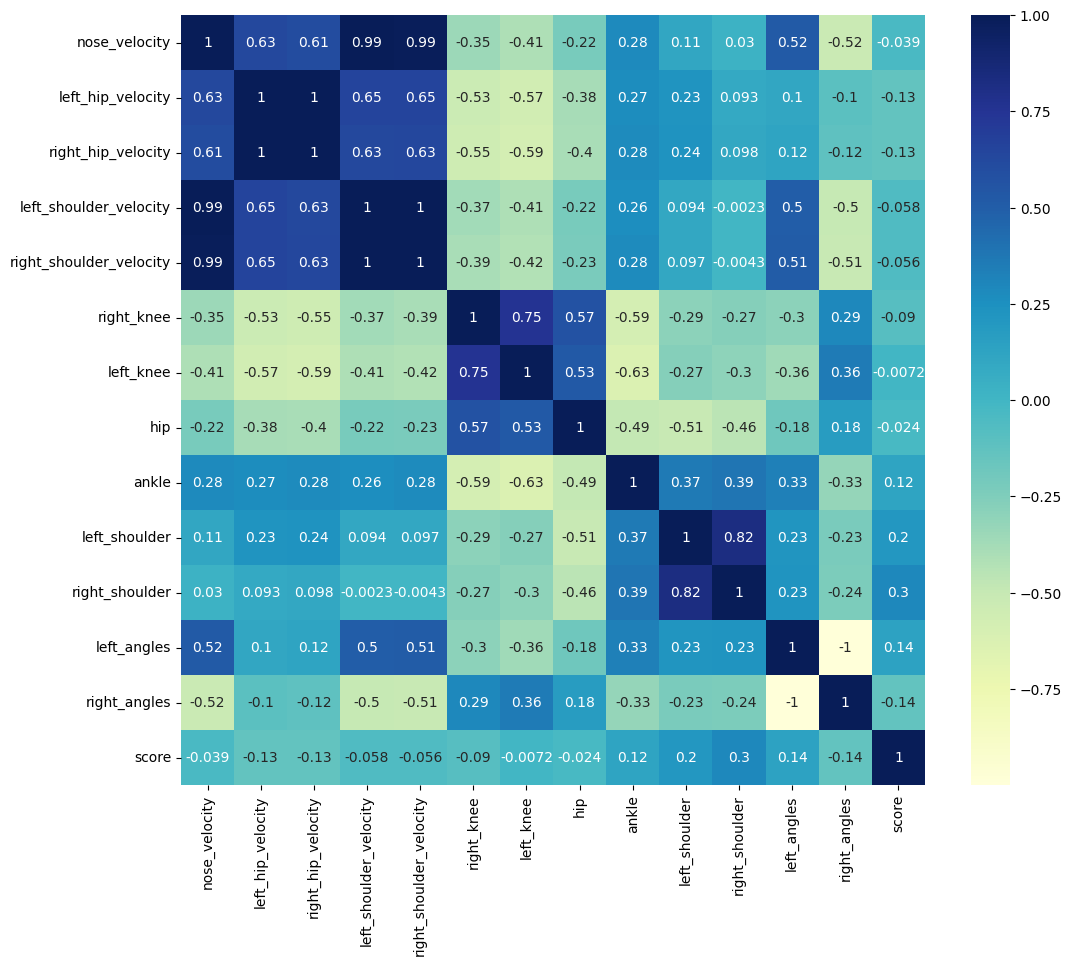

In [ ]:
corr = jump.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.show()

In [ ]:

def preprocessing_video(video_path, frame_size=(64, 64), num_frames=30):
    # Initialize a list to hold frames
    frames = []

    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get total number of frames
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the middle frame number
    middle_frame = total_frames // 2

    # Calculate the start frame number
    start_frame = max(0, middle_frame - num_frames // 2)

    # Set the video to start at the start_frame
    video.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while True:
        # Read a frame from the video
        ret, frame = video.read()

        # If the frame was successfully read
        if ret:
            # Resize the frame
            frame = cv2.resize(frame, frame_size)

            # Normalize pixel values
            frame = frame / 255.0

            # Add the frame to the list
            frames.append(frame)
        else:
            # If no frame was read then we've reached the end of the video
            break

        # If we've collected enough frames then we can stop reading the video
        if len(frames) == num_frames:
            break

    video.release()

    # Stack frames into a single numpy array
    frames = np.stack(frames)

    return frames

In [ ]:
jump.columns

Index(['video_path', 'action', 'nose_velocity', 'left_hip_velocity',
       'right_hip_velocity', 'left_shoulder_velocity',
       'right_shoulder_velocity', 'right_knee', 'left_knee', 'hip', 'ankle',
       'left_shoulder', 'right_shoulder', 'left_angles', 'right_angles',
       'score'],
      dtype='object')

In [ ]:
jump = jump.drop(columns=["action"])

In [ ]:
# Preprocess videos
video_jump = np.array([preprocessing_video(vp) for vp in jump['video_path']])

angle_velo_jump = jump[['nose_velocity', 'left_hip_velocity',
       'right_hip_velocity', 'left_shoulder_velocity',
       'right_shoulder_velocity', 'right_knee', 'left_knee', 'hip', 'ankle',
       'left_shoulder', 'right_shoulder', 'left_angles', 'right_angles']].values


# Convert the scores to a numpy array
y = jump['score'].values
y_adjusted = y-1

In [ ]:
video_jump_train, video_jump_test, angle_jump_train, angle_jump_test, jump_train, jump_test = train_test_split(video_jump, angle_velo_jump, y_adjusted, test_size=0.2, random_state=42)

In [ ]:
# Define the model
num_frames = video_jump_train.shape[1]
frame_height = video_jump_train.shape[2]
frame_width = video_jump_train.shape[3]
num_channels = video_jump_train.shape[4]
num_angles = angle_jump_train.shape[1]

In [ ]:
video_input = Input(shape=(num_frames, frame_height, frame_width, num_channels))

In [ ]:
angle_velo_jump = Input(shape=(num_angles,))

CNN+RNN for Jump

In [ ]:
# Define the CNN model for processing video
cnn_base = MobileNet(input_shape=(frame_height, frame_width, num_channels), weights='imagenet', include_top=False)
cnn_out = TimeDistributed(cnn_base)(video_input)  # Wrap the base model with TimeDistributed
cnn_out = TimeDistributed(Flatten())(cnn_out)
cnn = Model(inputs=video_input, outputs=cnn_out)

In [ ]:
rnn = LSTM(units=128)(cnn.output)

In [ ]:
dense = Dense(units=128, activation='relu')(angle_velo_jump)

In [ ]:
concat = Concatenate()([rnn, dense])

In [ ]:
output = Dense(units=1, activation='linear')(concat)

In [ ]:
model = Model(inputs=[cnn.input, angle_velo_jump], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error','mse'])

In [ ]:
his = model.fit([video_jump_train, angle_jump_train], jump_train,
          validation_data=([video_jump_test, angle_jump_test], jump_test),
          epochs=25, batch_size=16)

Epoch 1/25
5/5 [==============================] - 85s 15s/step - loss: 1.7240 - mean_absolute_error: 1.0583 - mse: 1.7240 - val_loss: 0.9180 - val_mean_absolute_error: 0.8603 - val_mse: 0.9180
Epoch 2/25
5/5 [==============================] - 76s 15s/step - loss: 0.5513 - mean_absolute_error: 0.6075 - mse: 0.5513 - val_loss: 0.4765 - val_mean_absolute_error: 0.5841 - val_mse: 0.4765
Epoch 3/25
5/5 [==============================] - 71s 14s/step - loss: 0.2707 - mean_absolute_error: 0.3959 - mse: 0.2707 - val_loss: 0.4071 - val_mean_absolute_error: 0.5377 - val_mse: 0.4071
Epoch 4/25
5/5 [==============================] - 76s 15s/step - loss: 0.2157 - mean_absolute_error: 0.3474 - mse: 0.2157 - val_loss: 0.4089 - val_mean_absolute_error: 0.5424 - val_mse: 0.4089
Epoch 5/25
5/5 [==============================] - 72s 14s/step - loss: 0.1296 - mean_absolute_error: 0.2732 - mse: 0.1296 - val_loss: 0.4033 - val_mean_absolute_error: 0.5440 - val_mse: 0.4033
Epoch 6/25
5/5 [===================

In [ ]:
y_pred = model.predict([video_jump_test, angle_jump_test])

1/1 [==============================] - 3s 3s/step


In [ ]:
rmse = sqrt(mean_squared_error(jump_test, y_pred))
r2 = r2_score(jump_test, y_pred)
print('Test RMSE:', rmse)
print('R2:', r2)

Test RMSE: 0.5345561629719917
R2: 0.3315782657980384


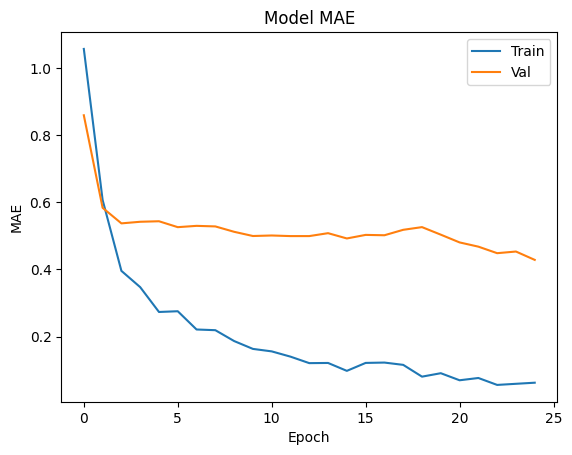

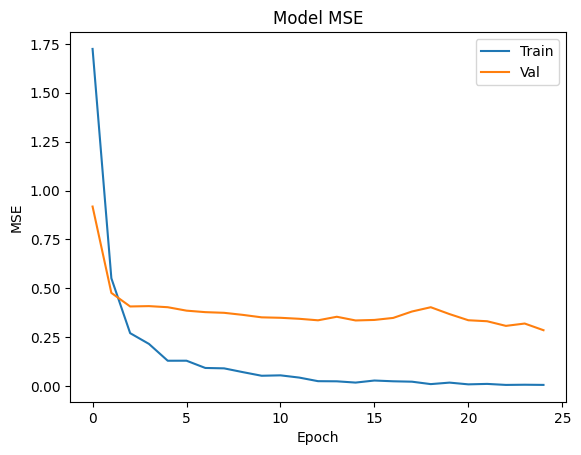

In [ ]:
plt.plot(his.history['mean_absolute_error'])
plt.plot(his.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(his.history['mse'])
plt.plot(his.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

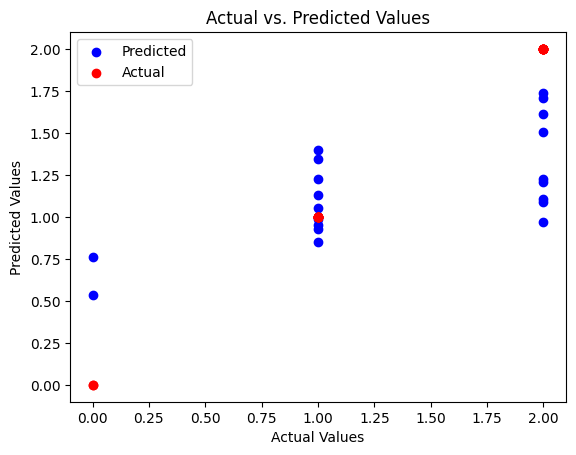

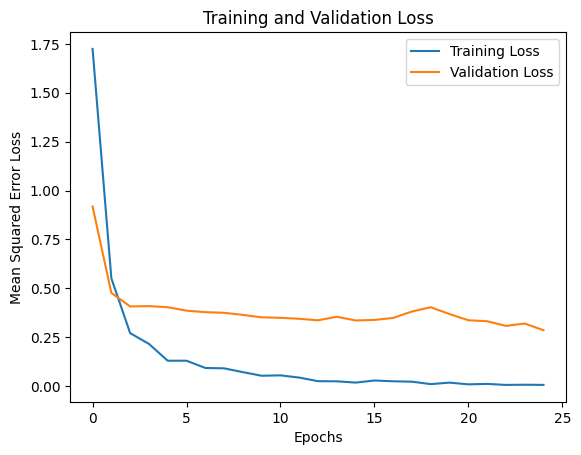

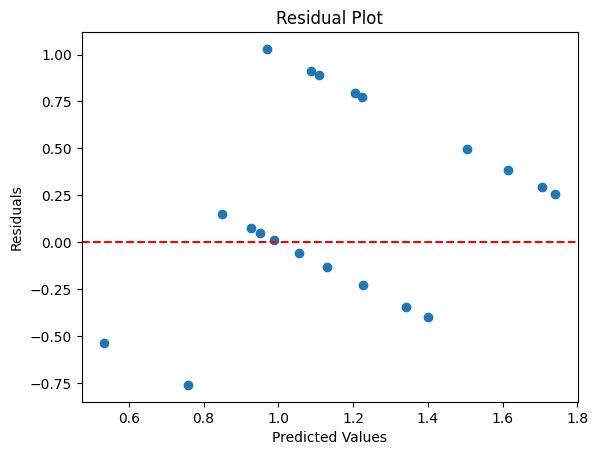

In [ ]:
plt.scatter(jump_test, y_pred, c='b', label='Predicted')  # Predicted values in blue
plt.scatter(jump_test, jump_test, c='r', label='Actual')     # Actual values in red
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

# Plot training and validation loss during training
plt.plot(his.history['loss'], label='Training Loss')
plt.plot(his.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



# Create an array of data point indices for the bar plot
residuals = jump_test - y_pred.flatten()

plt.scatter(y_pred.flatten(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Time Distributed CNN for Jump

In [ ]:
# Apply ConvNet to each frame in the video
x = TimeDistributed(Conv2D(64, (3,3), activation='relu'))(video_input)
x = TimeDistributed(MaxPooling2D((2,2)))(x)
x = TimeDistributed(Conv2D(128, (3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2,2)))(x)
x = TimeDistributed(Conv2D(256, (3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2,2)))(x)

In [ ]:
# Flatten the results and feed them into an LSTM layer
x = TimeDistributed(Flatten())(x)
x = LSTM(256, return_sequences=False, dropout=0.5)(x)
x = Model(inputs=video_input, outputs=x)

In [ ]:
y = Dense(64, activation="relu")(angle_velo_jump)
y = Dense(64, activation="relu")(y)
y = Model(inputs=angle_velo_jump, outputs=y)

In [ ]:
# Part 3: Combine both parts
combined = concatenate([x.output, y.output])

In [ ]:
# Add final layers
z = Dense(64, activation="relu")(combined)
z = Dense(64, activation="relu")(z)
z = Dense(1, activation="linear")(z)

In [ ]:
model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error','mse'])

In [ ]:
his = model.fit([video_jump_train, angle_jump_train], jump_train, epochs=30, batch_size=16,
          validation_data=([video_jump_test, angle_jump_test], jump_test))

Epoch 1/30
5/5 [==============================] - 67s 12s/step - loss: 1.1783 - mean_absolute_error: 0.9054 - mse: 1.1783 - val_loss: 0.4507 - val_mean_absolute_error: 0.5875 - val_mse: 0.4507
Epoch 2/30
5/5 [==============================] - 59s 12s/step - loss: 0.3640 - mean_absolute_error: 0.5221 - mse: 0.3640 - val_loss: 0.4953 - val_mean_absolute_error: 0.5824 - val_mse: 0.4953
Epoch 3/30
5/5 [==============================] - 58s 12s/step - loss: 0.3836 - mean_absolute_error: 0.5189 - mse: 0.3836 - val_loss: 0.4048 - val_mean_absolute_error: 0.5806 - val_mse: 0.4048
Epoch 4/30
5/5 [==============================] - 58s 12s/step - loss: 0.3127 - mean_absolute_error: 0.4693 - mse: 0.3127 - val_loss: 0.3776 - val_mean_absolute_error: 0.5515 - val_mse: 0.3776
Epoch 5/30
5/5 [==============================] - 58s 11s/step - loss: 0.2966 - mean_absolute_error: 0.4754 - mse: 0.2966 - val_loss: 0.3564 - val_mean_absolute_error: 0.5249 - val_mse: 0.3564
Epoch 6/30
5/5 [===================

In [ ]:
jump_pred = model.predict([video_jump_test, angle_jump_test])

1/1 [==============================] - 4s 4s/step


In [ ]:
rmse = sqrt(mean_squared_error(jump_test, jump_pred))
r2 = r2_score(jump_test, jump_pred)
print('Test RMSE:', rmse)
print('R2:', r2)

Test RMSE: 0.1301322522813026
R2: 0.9603873612074747


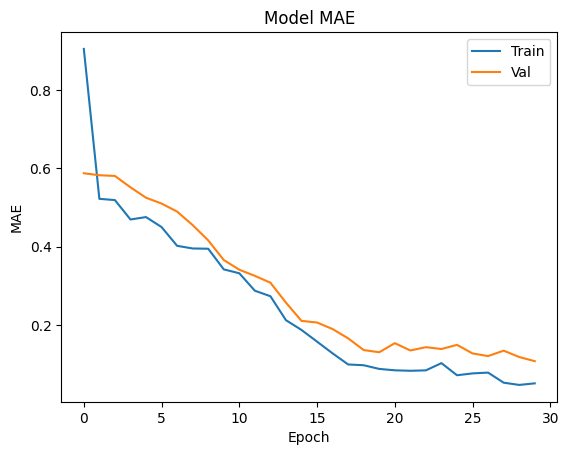

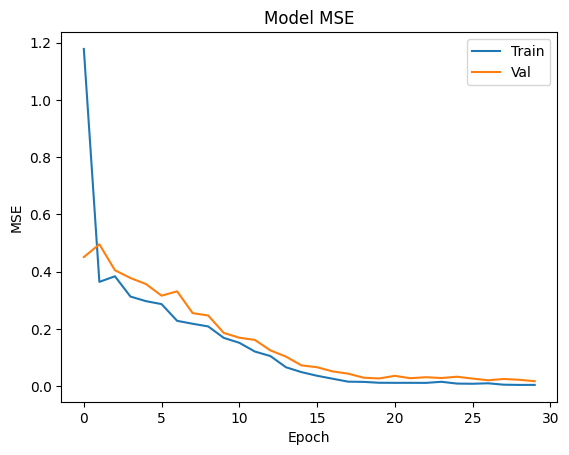

In [ ]:
plt.plot(his.history['mean_absolute_error'])
plt.plot(his.history['val_mean_absolute_error'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(his.history['mse'])
plt.plot(his.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

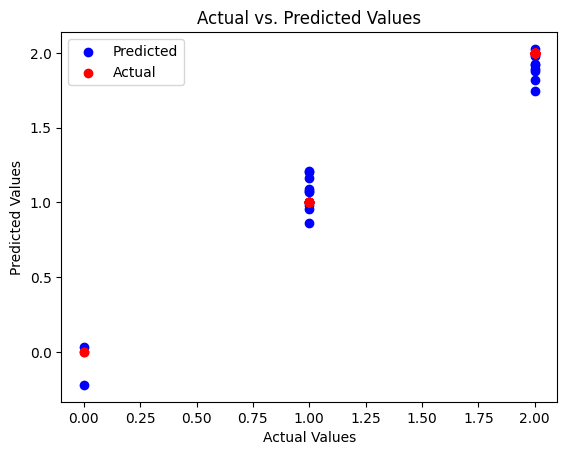

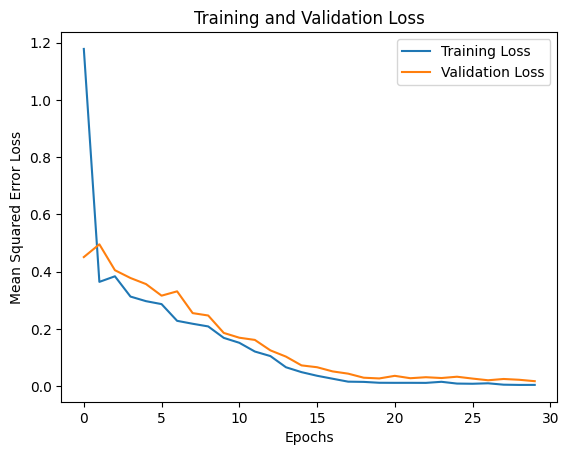

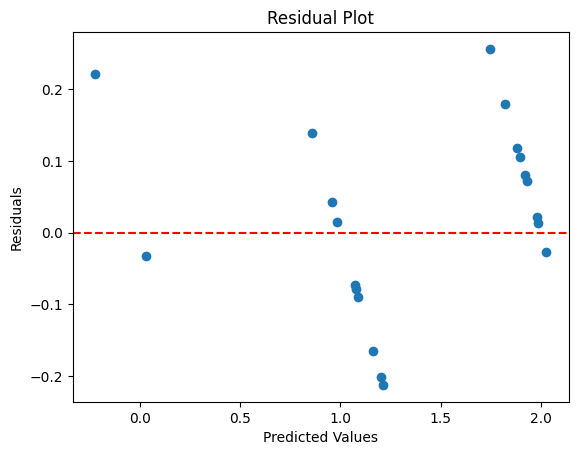

In [ ]:
plt.scatter(jump_test, jump_pred, c='b', label='Predicted')  # Predicted values in blue
plt.scatter(jump_test, jump_test, c='r', label='Actual')     # Actual values in red
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

# Plot training and validation loss during training
plt.plot(his.history['loss'], label='Training Loss')
plt.plot(his.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Create an array of data point indices for the bar plot
residuals = jump_test - jump_pred.flatten()

plt.scatter(jump_pred.flatten(), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

#Classification Models

Time Dristributed CNN for Squat

In [ ]:
# X = squat.drop(columns=['score'])
# y = squat['score']

# video_path_mapping = {path: i for i, path in enumerate(X['video_path'].unique())}
# X['video_path'] = X['video_path'].map(video_path_mapping)
# categorical_columns = ['video_path']
# numerical_columns = [col for col in X.columns if col not in categorical_columns]
# smote = SMOTENC(categorical_features=[0], random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# # Convert video_path back to original string representation
# X_resampled['video_path'] = X_resampled['video_path'].map({v: k for k, v in video_path_mapping.items()})
# y_resampled = pd.DataFrame({'score': y_resampled})

In [ ]:
# scaler = StandardScaler()

In [ ]:
# angle_velocity_columns = ['nose_velocity', 'left_hip_velocity', 'right_hip_velocity',
#                           'left_shoulder_velocity', 'right_shoulder_velocity',
#                           'right_knee', 'left_knee', 'hip',  "ankle",
#                           'left_shoulder', 'right_shoulder', 'left_angles', 'right_angles']

In [ ]:
# X_resampled[angle_velocity_columns] = scaler.fit_transform(X_resampled[angle_velocity_columns])

In [ ]:
# y_resampled

,score
0,1
1,1
2,1
3,1
4,1
...,...
238,3
239,3
240,3
241,3


In [ ]:
# scaler = StandardScaler()

In [ ]:
# video_squat = np.array([preprocessing_video(vp) for vp in X_resampled['video_path']])

# angle_velo_squat = X_resampled[['nose_velocity', 'left_hip_velocity',
#        'right_hip_velocity', 'left_shoulder_velocity',
#        'right_shoulder_velocity', 'right_knee', 'left_knee', 'hip', 'ankle',
#        'left_shoulder', 'right_shoulder', 'left_angles', 'right_angles']].values


# # Convert the scores to a numpy array
# y = y_resampled['score'].values
# y_adjusted = y-1

In [ ]:
video_squat_train, video_squat_test, angle_squat_train, angle_squat_test, squat_train, squat_test = train_test_split(video_squat, angle_velo_squat, y_adjusted, test_size=0.2, random_state=42)

In [ ]:
num_frames = video_squat_train.shape[1]
frame_height = video_squat_train.shape[2]
frame_width = video_squat_train.shape[3]
num_channels = video_squat_train.shape[4]
num_angles = angle_squat_train.shape[1]

In [ ]:
video_input = Input(shape=(num_frames, frame_height, frame_width, num_channels))
angles_velo_squat = Input(shape=(num_angles,))

In [ ]:
# Apply ConvNet to each frame in the video
x = TimeDistributed(Conv2D(16, (3,3), activation='relu'))(video_input)
x = TimeDistributed(MaxPooling2D((2,2)))(x)
x = TimeDistributed(Conv2D(32, (3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2,2)))(x)
x = TimeDistributed(Conv2D(64, (3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2,2)))(x)

In [ ]:
# Flatten the results and feed them into an LSTM layer
x = TimeDistributed(Flatten())(x)
x = LSTM(64, return_sequences=False, dropout=0.5)(x)
x = Model(inputs=video_input, outputs=x)

In [ ]:
y = Dense(16, activation="relu")(angle_velo_squat)
y = Dense(16, activation="relu")(y)
y = Model(inputs=angle_velo_squat, outputs=y)

In [ ]:
# Part 3: Combine both parts
combined = concatenate([x.output, y.output])

In [ ]:
# Add final layers
z = Dense(16, activation="relu")(combined)
z = Dense(16, activation="relu")(z)
z = Dense(3, activation="sigmoid")(z)

In [ ]:
from tensorflow.keras.optimizers import SGD
model = Model(inputs=[x.input, y.input], outputs=z)
optimizer = SGD(lr=0.01, momentum=0.9)

In [ ]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit([video_squat_train, angle_squat_train], squat_train, epochs=30, batch_size=16,
          validation_data=([video_squat_test, angle_squat_test], squat_test))

Epoch 1/30
6/6 [==============================] - 36s 3s/step - loss: 1.0218 - accuracy: 0.5904 - val_loss: 0.7128 - val_accuracy: 0.8571
Epoch 2/30
6/6 [==============================] - 11s 2s/step - loss: 0.7081 - accuracy: 0.7590 - val_loss: 0.5563 - val_accuracy: 0.8571
Epoch 3/30
6/6 [==============================] - 20s 3s/step - loss: 0.6696 - accuracy: 0.7590 - val_loss: 0.5760 - val_accuracy: 0.8571
Epoch 4/30
6/6 [==============================] - 12s 2s/step - loss: 0.6478 - accuracy: 0.7590 - val_loss: 0.6153 - val_accuracy: 0.8571
Epoch 5/30
6/6 [==============================] - 30s 5s/step - loss: 0.6408 - accuracy: 0.7590 - val_loss: 0.6430 - val_accuracy: 0.8571
Epoch 6/30
6/6 [==============================] - 22s 4s/step - loss: 0.6316 - accuracy: 0.7590 - val_loss: 0.6034 - val_accuracy: 0.8571
Epoch 7/30
6/6 [==============================] - 28s 5s/step - loss: 0.6129 - accuracy: 0.7590 - val_loss: 0.5431 - val_accuracy: 0.8571
Epoch 8/30
6/6 [==================

In [ ]:
squat_pred = model.predict([video_squat_test, angle_squat_test])

1/1 [==============================] - 2s 2s/step


In [ ]:
loss, accuracy=model.evaluate([video_squat_test,angle_squat_test],squat_test)
print("accuracy:{:.4f}",format(accuracy))

1/1 [==============================] - 1s 1s/step - loss: 0.2250 - accuracy: 0.9048
accuracy:{:.4f} 0.9047619104385376


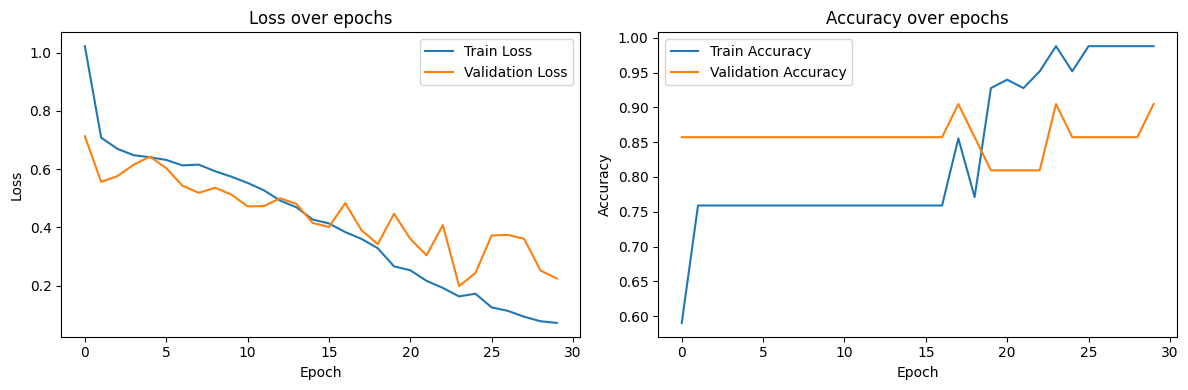

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

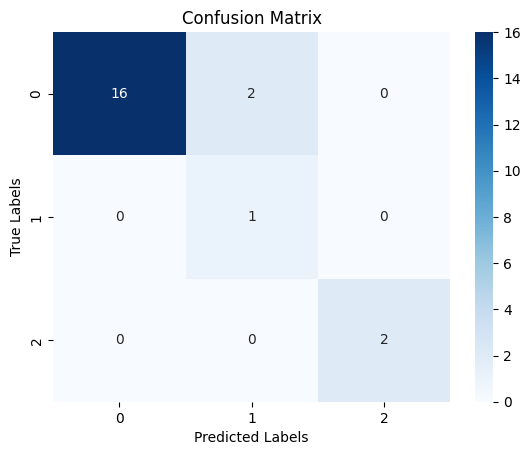

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(squat_pred, axis=1)
conf_mat = confusion_matrix(squat_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Time DIstributed CNN for Jump

In [ ]:
# Apply ConvNet to each frame in the video
x = TimeDistributed(Conv2D(64, (3,3), activation='relu'))(video_input)
x = TimeDistributed(MaxPooling2D((2,2)))(x)
x = TimeDistributed(Conv2D(128, (3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2,2)))(x)
x = TimeDistributed(Conv2D(256, (3,3), activation='relu'))(x)
x = TimeDistributed(MaxPooling2D((2,2)))(x)

In [ ]:
# Flatten the results and feed them into an LSTM layer
x = TimeDistributed(Flatten())(x)
x = LSTM(256, return_sequences=False, dropout=0.5)(x)
x = Model(inputs=video_input, outputs=x)

In [ ]:
y = Dense(64, activation="relu")(angle_velo_jump)
y = Dense(64, activation="relu")(y)
y = Model(inputs=angle_velo_jump, outputs=y)

In [ ]:
# Part 3: Combine both parts
combined = concatenate([x.output, y.output])

In [ ]:
# Add final layers
z = Dense(64, activation="relu")(combined)
z = Dense(64, activation="relu")(z)
z = Dense(3, activation="softmax")(z)

In [ ]:
model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit([video_jump_train, angle_jump_train], jump_train, epochs=30, batch_size=16,
          validation_data=([video_jump_test, angle_jump_test], jump_test))

In [ ]:
jump_pred = model.predict([video_jump_test, angle_jump_test])

In [ ]:
loss, accuracy=model.evaluate([video_squat_test,angle_squat_test],squat_test)
print("accuracy:{:.4f}",format(accuracy))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

CNN+RNN for JUMP

In [ ]:
# Define the CNN model for processing video
cnn_base = MobileNet(input_shape=(frame_height, frame_width, num_channels), weights='imagenet', include_top=False)
cnn_out = TimeDistributed(cnn_base)(video_input)  # Wrap the base model with TimeDistributed
cnn_out = TimeDistributed(Flatten())(cnn_out)
cnn = Model(inputs=video_input, outputs=cnn_out)

In [ ]:
rnn = LSTM(units=128)(cnn.output)

In [ ]:
dense = Dense(units=128, activation='relu')(angle_velo_jump)

In [ ]:
concat = Concatenate()([rnn, dense])

In [ ]:
output = Dense(units=3, activation='softmax')(concat)

In [ ]:
model = Model(inputs=[cnn.input, angle_velo_jump], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error','mse'])


In [ ]:
history = model.fit([video_jump_train, angle_jump_train], jump_train,
          validation_data=([video_jump_test, angle_jump_test], jump_test),
          epochs=25, batch_size=16)

Epoch 1/25
5/5 [==============================] - 152s 17s/step - loss: 1.0800 - accuracy: 0.4487 - val_loss: 1.1649 - val_accuracy: 0.4500
Epoch 2/25
5/5 [==============================] - 85s 17s/step - loss: 0.8750 - accuracy: 0.5641 - val_loss: 1.0817 - val_accuracy: 0.4500
Epoch 3/25
5/5 [==============================] - 91s 19s/step - loss: 0.7304 - accuracy: 0.6538 - val_loss: 1.0576 - val_accuracy: 0.4000
Epoch 4/25
5/5 [==============================] - 85s 17s/step - loss: 0.5785 - accuracy: 0.7821 - val_loss: 0.9714 - val_accuracy: 0.4500
Epoch 5/25
5/5 [==============================] - 81s 16s/step - loss: 0.5104 - accuracy: 0.8077 - val_loss: 0.9363 - val_accuracy: 0.5000
Epoch 6/25
5/5 [==============================] - 79s 16s/step - loss: 0.3578 - accuracy: 0.8846 - val_loss: 0.9286 - val_accuracy: 0.6000
Epoch 7/25
5/5 [==============================] - 85s 17s/step - loss: 0.3273 - accuracy: 0.8974 - val_loss: 0.8924 - val_accuracy: 0.5500
Epoch 8/25
5/5 [==========

In [ ]:
y_pred = model.predict([video_jump_test, angle_jump_test])

1/1 [==============================] - 3s 3s/step


In [ ]:
loss, accuracy  = model.evaluate([video_squat_test, angle_squat_test], squat_test)
print("Accuracy: {:.4f}".format(accuracy))

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

CNN+RNN for Squat

In [ ]:
# Define the CNN model for processing video
cnn_base = MobileNet(input_shape=(frame_height, frame_width, num_channels), weights='imagenet', include_top=False)
cnn_out = TimeDistributed(cnn_base)(video_input)  # Wrap the base model with TimeDistributed
cnn_out = TimeDistributed(Flatten())(cnn_out)
cnn = Model(inputs=video_input, outputs=cnn_out)

In [ ]:
rnn = LSTM(units=128)(cnn.output)

In [ ]:
dense = Dense(units=128, activation='relu')(angle_velo_squat)

In [ ]:
concat = Concatenate()([rnn, dense])

In [ ]:
output = Dense(units=3, activation='softmax')(concat)

In [ ]:
model = Model(inputs=[cnn.input, angle_velo_squat], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error','mse'])


In [ ]:
history = model.fit([video_squat_train, angle_squat_train], squat_train,
          validation_data=([video_squat_test, angle_squat_test], squat_test),
          epochs=25, batch_size=16)

Epoch 1/25
6/6 [==============================] - 105s 15s/step - loss: 0.4687 - accuracy: 0.8313 - val_loss: 0.4794 - val_accuracy: 0.8571
Epoch 2/25
6/6 [==============================] - 90s 15s/step - loss: 0.1875 - accuracy: 0.9398 - val_loss: 0.6105 - val_accuracy: 0.8571
Epoch 3/25
6/6 [==============================] - 81s 13s/step - loss: 0.1222 - accuracy: 0.9398 - val_loss: 0.6031 - val_accuracy: 0.8571
Epoch 4/25
6/6 [==============================] - 92s 15s/step - loss: 0.2397 - accuracy: 0.9398 - val_loss: 0.5444 - val_accuracy: 0.8571
Epoch 5/25
6/6 [==============================] - 82s 13s/step - loss: 0.0899 - accuracy: 0.9880 - val_loss: 0.6553 - val_accuracy: 0.8571
Epoch 6/25
6/6 [==============================] - 88s 14s/step - loss: 0.1521 - accuracy: 0.9398 - val_loss: 0.4464 - val_accuracy: 0.8571
Epoch 7/25
6/6 [==============================] - 85s 14s/step - loss: 0.0580 - accuracy: 0.9880 - val_loss: 0.4091 - val_accuracy: 0.8571
Epoch 8/25
6/6 [==========

In [ ]:
y_pred = model.predict([video_squat_test, angle_squat_test])

1/1 [==============================] - 3s 3s/step


In [ ]:
loss, accuracy  = model.evaluate([video_squat_test, angle_squat_test], squat_test)
print("Accuracy: {:.4f}".format(accuracy))

1/1 [==============================] - 2s 2s/step - loss: 0.0847 - accuracy: 1.0000
Accuracy: 1.0000


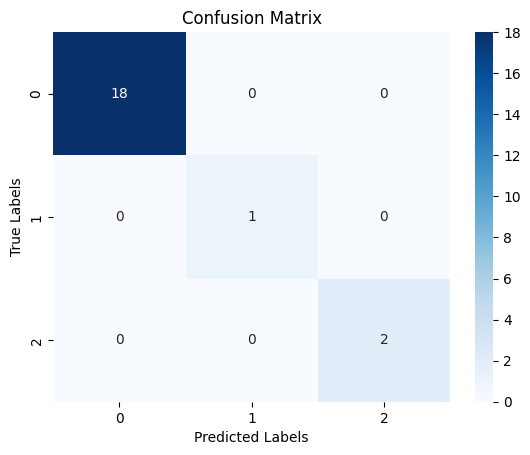

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(y_pred, axis=1)
conf_mat = confusion_matrix(squat_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

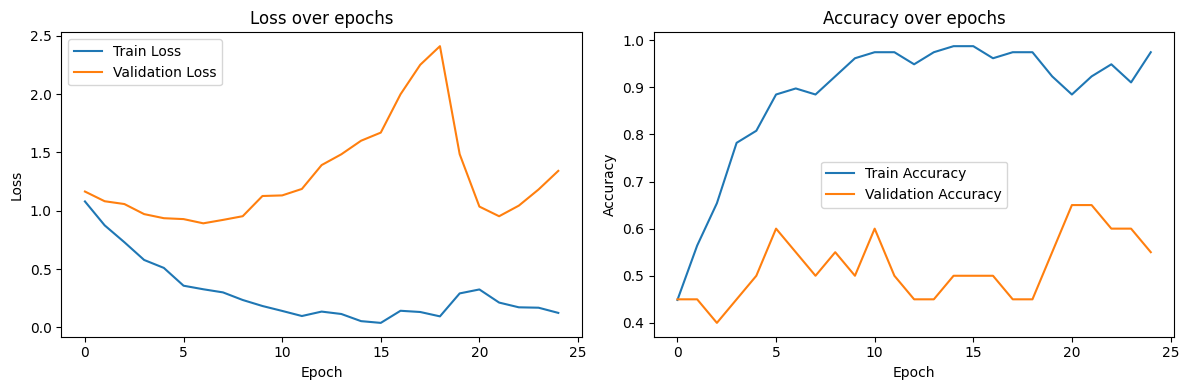

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()